# How to Visualize Differentially Private Datasets in Matplotlib with Antigranular

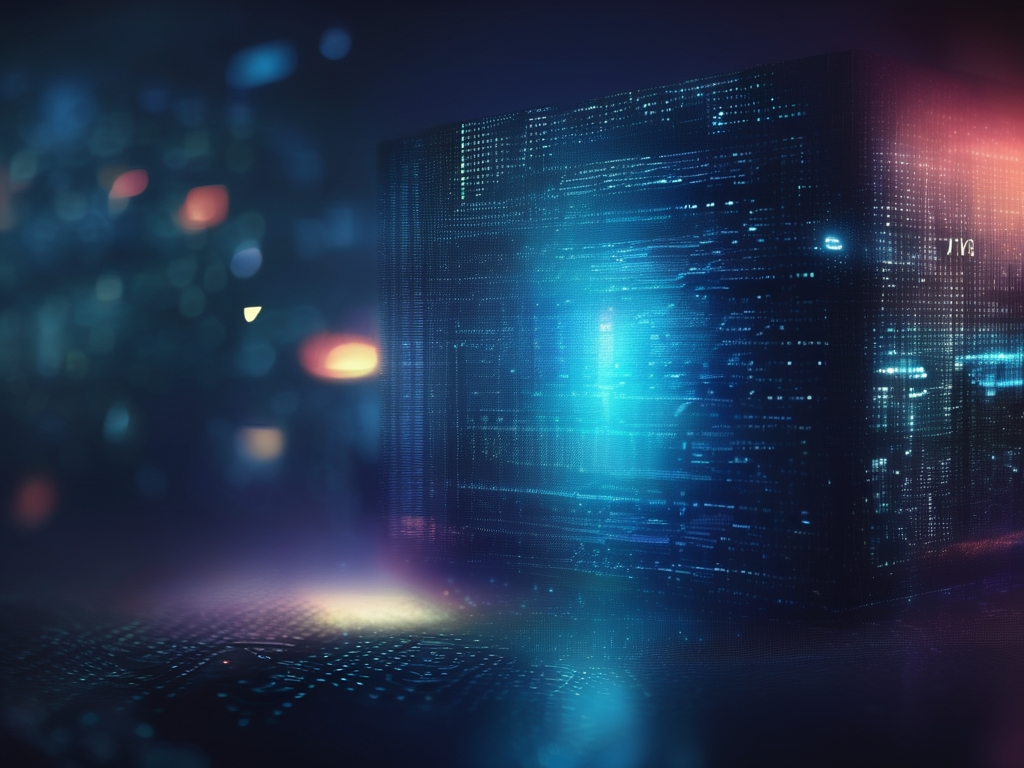

## Introduction

In March 2024, Oblivious AI held a bootcamp on differential privacy at Oxford University. While attending the event, I got to work on a very interesting problem - preserving individual privacy in web analytics datasets using differential privacy. 

Many websites can track mouse and keyboard activity of their users by capturing features such as X and Y coordinates, velocity, and analyze this data with the intent to improve website experience. However, since this data is collected at user level, it is only possible to share it with third parties after anonymization.

The question we tackled was - can a malicious actor de-anonymize this data by analyzing users’ mouse and keyboard tracking data? Specifically, we wanted to explore whether older people are more at risk of a targeted attack if the speed of their typing and mouse movements are exposed.

On the surface, age group itself might seem like a harmless piece of information. However, certain parties can exploit it in several ways such as:

- __Targeted scams__: Knowing someone's age group can help scammers tailor their approach. For example, they might target older adults with pension scams or younger people with social media phishing attempts.
- __Identity theft__: Age group can be a puzzle piece in a larger identity theft scheme. Combined with other pieces of information, it could be used to answer security questions or appear more believable when impersonating someone.

So, me and my teammate, Devyani Gauri had an important problem in our hands. Our first task was to prove that this was a fairly simple attack given a mouse tracking dataset. For this purpose, we used an open source dataset of a whack-a-mole game. We were able to conclusively prove that older people (above the age of 50) can be identified with a simple classification model using just the velocity of mouse movement.

This is a great example of data that should be shared in a differentially private manner. However, this brought a larger challenge to our attention : how can we visualize such data to maintain overall trends without enabling tracing of data points back to specific individuals from the visuals?

## Differential privacy refresher

Imagine "Einzelnen" (German for "individual") is in some dataset. Differential privacy aims to make Einzelnen's presence or absence imperceptible to any kind of mathematical analysis. This is achieved by adding controlled noise to the results. 

Let's say we're calculating the average age. Differential privacy guarantees that the final average will be accurate, but with some added noise. This noise ensures Einzelnen's (or anyone else's for that matter) specific age cannot be derived from the final result, even if their data was removed.

The accuracy of calculations in differential privacy is affected by a parameter called epsilon (ε). Lower ε signifies stronger privacy guarantees but with more noise, potentially affecting accuracy. Using too little epsilon can return a useless answer like five times the original result while too much might just give it away. 

Because of such high a degree of privacy guarantee, differential privacy has applications in finance, economics, business, healthcare or any other high-risk domains where even the employees who handle and analyze the data can't be allowed to "peek inside". 

## What is Antigranular?

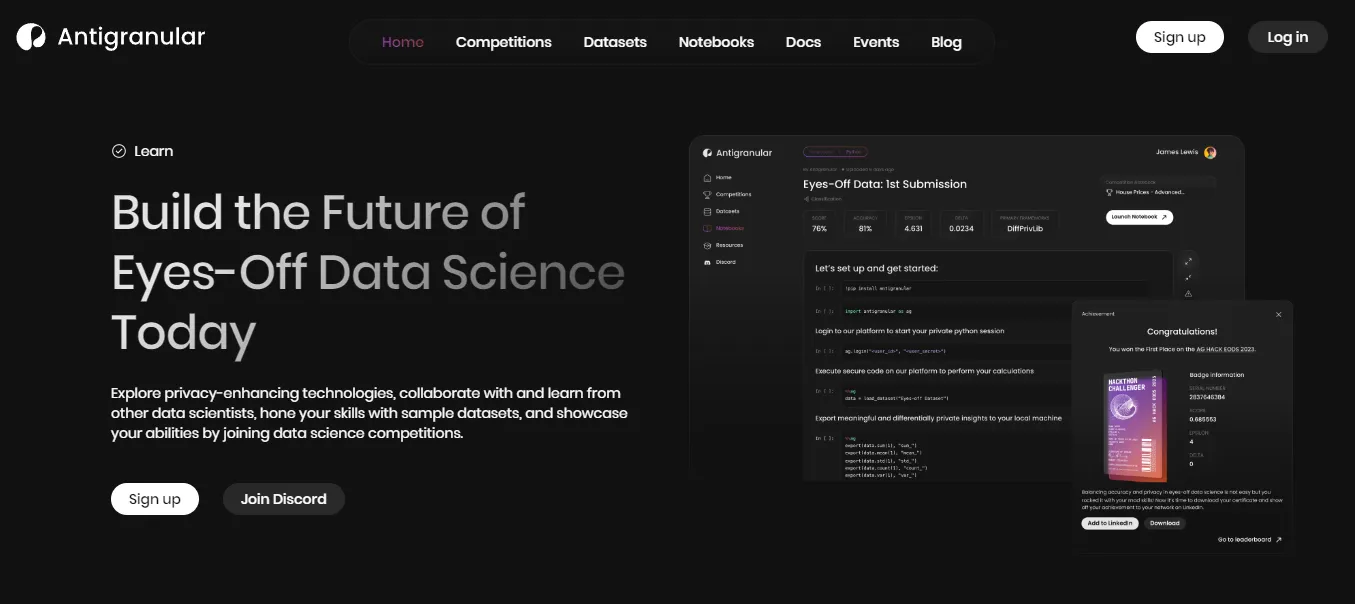

Antigranular (developed by Oblivious) is a secure and trusted platform to host your company data privately or publicly under differential privacy. 

The platform stores data in secure AWS Nitro Enclaves that use cryptographic attestation. Each enclave runs Private Python runtimes, which are special modified versions of Python that only include select functions and libraries designed with differential privacy in mind.

I've written about the AntiGranular platform in detail in these two articles. You can read them here:
- [Antigranular: How to Access Sensitive Datasets Without Looking At Them](https://medium.com/towards-artificial-intelligence/antigranular-how-to-access-sensitive-datasets-without-looking-at-them-44090cb22d8a)
- [How to Explore And Clean Sensitive Data You Can't Even See With Antigranular](https://medium.com/datadriveninvestor/how-to-explore-and-clean-sensitive-data-you-cant-even-see-with-antigranular-14efca3cfcae)

This article addresses the painful data visualization aspect of differential privacy and by extension, the Antigranular platform itself. Since many of the visuals we use in regular data science projects such as scatterplots, histograms, boxplots and so on are prone to privacy attacks, you can't access Matplotlib or any Python plotting library inside Antigranular. 

However, after reading this article, you will be able to use any plotting library or function you want on differentially private datasets. This will be possible by using a novel approach our team came up during the Differential Privacy Bootcamp at Oxford University. 

Let's get started!

## So, how to visualize DP datasets with Matplotlib?

__SETUP__

First off, we will need an open-source dataset and its differentially private version to create the same visuals on both and compare them. Just like many of my other articles, we will go with the Diamonds dataset from Kaggle which is built into Seaborn and into the Antigranular platform itself.

So, the very first thing to do is for you to create a virtual environment, preferably Conda, and install a few libraries we need:

```bash
$ conda create -n antigranular python==3.9 -y
$ conda activate antigranular
$ pip install antigranular seaborn matplotlib pandas numpy
```

`antigranular` is the official Python interface to interact with the Antigranular platform and its Nitro Enclaves. Next, run the following two commands, please:

```bash
$ pip install ipykernel
$ ipython kernel install --user --name=antigranular
```

The last command will add the `antigranular` virtual environment to your Jupyter as a kernel. And yes, we will be working inside Jupyter notebooks - it is a requirement for Antigranular. 

Then, you can go to [https://www.antigranular.com/](https://www.antigranular.com/) and create your free account. There, you will be able to copy a code snippet with your login credentials to connect to the Nitro Enclave that holds the differentially private Diamonds dataset:

![](images/diamonds.gif)

Run the snippet in a new notebook:

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()  # Hide this block

True

In [2]:
import antigranular as ag

session = ag.login(
    os.getenv("USER_ID"),
    os.getenv("USER_SECRET"),
    dataset="Diamonds Dataset",
)

local_host_port: d29a857c-70e2-4bb4-8880-10ebfcaf3880
server_hostname: ip-100-100-16-102.eu-west-1.compute.internal
tls_cert_name: ip-100-100-16-102.eu-west-1.compute.internal_d29a857c-70e2-4bb4-8880-10ebfcaf3880
Dataset "Diamonds Dataset" loaded to the kernel as diamonds_dataset
Key Name                       Value Type     
---------------------------------------------
train_x                        PrivateDataFrame
train_y                        PrivateDataFrame
test_x                         DataFrame      

Connected to Antigranular server session id: 0f4c3ca8-43ed-4256-8a64-626e872d3b43, the session will time out if idle for 25 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


Once you run the copied code, you will see two important messages:
- A new object named `diamonds_dataset` has been created that contains `train_X` and `train_y` arrays (more on them later).
- `%%ag` magic command has been registered.

The `%%ag` magic command is a secure bridge that connects your Jupyter notebook to the Nitro Enclave. This means that if you want a cell to be executed using the enclave, you add the `%%ag` code to the top. 

For example, since `diamonds_dataset` is inside the enclave, the below code won't work:

```python
train_x = diamonds_dataset["train_x"]
train_y = diamonds_dataset["train_y"]

print(train_x.columns)
```

```
NameError: name 'diamonds_dataset' is not defined
```

But if you add the `%%ag`, it will work just as expected:

In [3]:
%%ag

train_x = diamonds_dataset["train_x"]
train_y = diamonds_dataset["train_y"]

ag_print(train_x.columns)

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']



> Note: `ag_print` is a differentially private version of Python `print` function. We will be using it a lot today.

From now on, any code cell that uses the `train_x` and `train_y` arrays must have the `%%ag` magic to work. 

By the way, I said that Pandas isn't supported inside AG, so what are `train_x` and `train_y`? Well, they are `PrivateDataFrame` objects which are the same as Pandas DataFrames but with a select differentially private methods:

In [4]:
%%ag

from op_pandas import PrivateDataFrame, PrivateSeries

In [5]:
%%ag

ag_print(train_x.describe(eps=0.5))

              carat         depth  ...             y             z
count  37888.000000  37659.000000  ...  37744.000000  37871.000000
mean       0.797886     61.638637  ...      5.602031      3.411750
std        0.465529      1.144270  ...      4.530112      0.918466
min        0.200000     43.000000  ...      0.000000      0.000000
25%        0.372987     60.060053  ...      5.389163      2.724342
50%        0.697166     61.678821  ...      5.697610      3.645499
75%        1.132747     62.139533  ...      5.740300      3.970791
max        3.279857     78.337596  ...     41.038437      9.342939

[8 rows x 6 columns]



Above, we ran a DP version of `describe` function, which has an `eps` (epsilon) parameter. The more epsilon you spend, the closer the output will be to that of Pandas `.describe()`. To keep the balance between total noise and utility, an epsilon between 0.1 and 1 is usually enough. 

Now, that we have covered the fundamentals, let's move on to the data visualization part. 

### A novel approach of plotting - histogram binning

The problem with most visuals such as bar charts, pie charts or scatterplots is that they require the exact values of datapoints to put them on a graph. Some plots like scatter plots or KDEs even need the entire distribution.

But, as you might guess, that doesn't fly well with differential privacy because you can't ask a DP dataset "What is the exact value of row N and column M?". So, the challenge in visualizing DP datasets is to preserve the original trend in a feature or the relationship between features but still adhere to DP standards. 

The way our team solved this was by using __histogram binning__. Differentially private histograms were long supported in Antigranular, so you could already do this:

In [6]:
%%ag

# Don't forget some epsilon
carat_hist_data = train_x.hist(column="carat", eps=1, bins=10)

export(carat_hist_data, "carat_hist_data")

Setting up exported variable in local environment: carat_hist_data


The `hist` function calculates the bin ranges and the number of datapoints that lie in each bin, which we are storing as `carat_hist_data`. The `export` function lets us download the result to our local runtime so we can feed it to Matplotlib (it isn't supported in AG).

Now, to plot the result, we can run the following snippet:

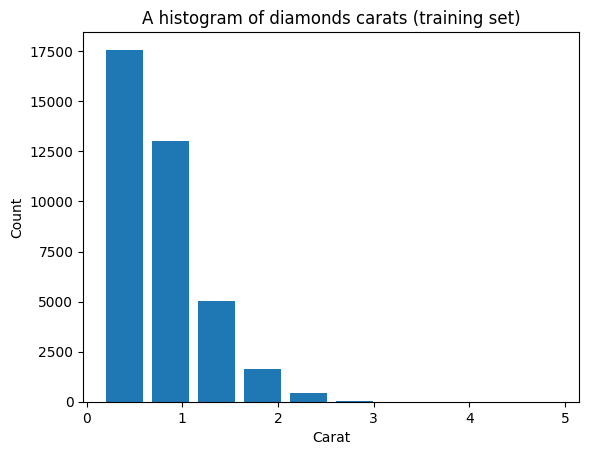

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract bin counts and bin edges
counts, bin_edges = carat_hist_data

# Create a histogram with plt.bar
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges) * 0.8, align="edge")

plt.xlabel("Carat")
plt.ylabel("Count")
plt.title("A histogram of diamonds carats (training set)")

# Display the plot
plt.show()

What is differentially private about this histogram? Well, as you may have already guessed, the counts in each bin are close to the actual bin counts but they are noisy counts, making them private. But the original histogram trend is there which you can verify using the open-source version of diamonds built into Seaborn:

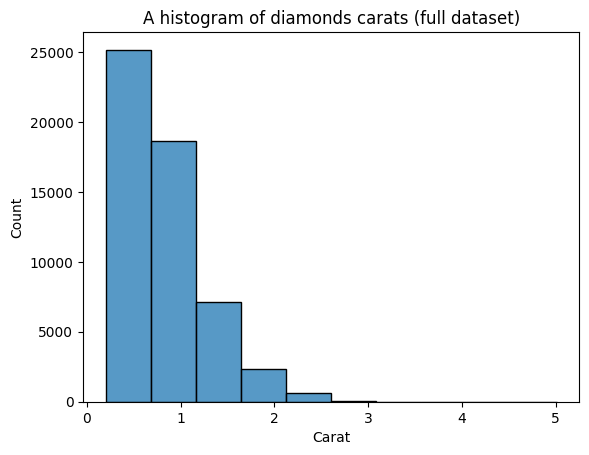

In [8]:
import seaborn as sns

diamonds = sns.load_dataset("diamonds")

sns.histplot(diamonds["carat"], bins=10)
plt.xlabel("Carat")
plt.title("A histogram of diamonds carats (full dataset)");

So, how do we go from DP histograms to a DP another plot, say scatterplots? 

Let's say this is an original histogram of distribution X:

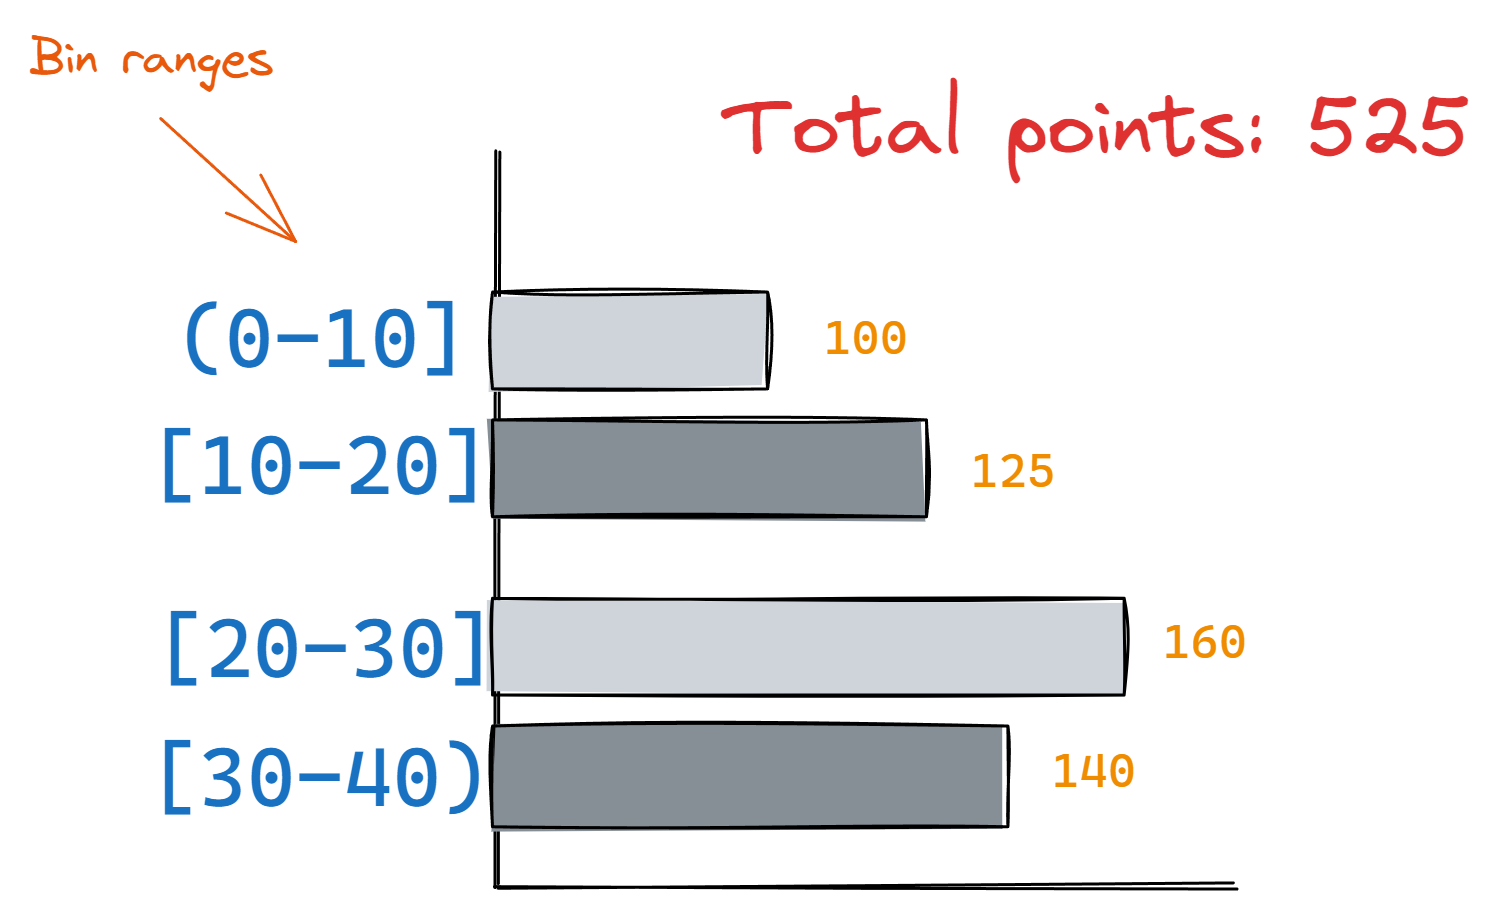

There are a total of 525 datapoints and four bins. To recreate a differentially private version of distribution X, we can create a DP histogram of X, retrieving bin ranges and bin counts and then, sample the same number of random numbers that are within each bin range.

The distribution would as closely resemble the original X distribution as possible under the given epsilon. So, we wouldn't be doing any complex math to apply differential privacy, it is already done for us using the `.hist` function of AG. 

Step-by-step, the process looks like this:

1. Get bin ranges and bin counts for the given distribution using the `.hist` function of private dataframes in AG.
2. Create an empty array to store the new DP distribution.
3. Sample the same number of random numbers as the bin counts in each bin range.
4. Combine all sampled numbers together into the empty array.
5. Export the array containing the DP distribution locally for plotting.
6. Plot the distribution using any compatible Matplotlib or Seaborn function.

Let's implement this in code:

```python
%%ag

import numpy as np
from op_pandas import PrivateDataFrame


def dp_distribution(
    pdf: PrivateDataFrame, col_name: str, eps: int = 1, bins: int = 100
):
    # Create an array to store recreated DP distributions
    private_distribution = []

    pass
```

1. We start by creating a function named `dp_distribution` that accepts:
- `pdf`: A private dataframe
- `col_name`: The name of the column to recreate with histogram binning
- `eps`: Epsilon, with a default value of 1
- `bins`: The number of bins, with a default value of 100

2. We create an empty list to store the recreated distribution from `col_name`.
3. We calculate histogram bin counts and bin edges using `.hist` for the given column.

```python
%%ag


def dp_distribution(
    pdf: PrivateDataFrame, col_name: str, eps: int = 1, bins: int = 100
):
    # Create a 1D histogram
    counts, bin_edges = pdf.hist(eps=eps, column=col_name, bins=bins)

    # Create an empty to list to store the recreated distribution
    private_distribution = []

    pass
```

4. In a `for` loop, we uniformly sample new points that are bounded by the ranges of each bin using `numpy`. As mentioned earlier, the count of new points is given by `counts`.

In [9]:
%%ag

counts, bin_edges = train_x.hist(eps=1, column="carat", bins=100)

In [10]:
%%ag
import numpy as np

private_distribution = []

for x in range(len(bin_edges) - 1):
    # Define the ranges for the current bin
    low_x = bin_edges[x]
    high_x = bin_edges[x + 1]

    # Extract the count for the current bin
    c = counts[x]

    # Sample new points uniformly within each bin's range
    new_points_x = np.random.uniform(low=low_x, high=high_x, size=int(c))

    # Add the points to final distribution
    private_distribution.extend(new_points_x)

In [11]:
%%ag


import numpy as np


def dp_distribution(
    pdf: PrivateDataFrame, col_name: str, eps: int = 1, bins: int = 100
):
    # Create an array to store the recreated DP distribution
    private_distribution = []

    # Create a 1D histogram for the column
    counts, bin_edges = pdf.hist(eps=eps, column=col_name, bins=bins)

    # Apply uniform sampling for each bin in the histogram
    # We uniformly sample new points bounded by the ranges of each bin
    # The number of new points in each bin is controlled by `counts` generated above
    for x in range(len(bin_edges) - 1):
        # Define the ranges for the current bin
        low_x = bin_edges[x]
        high_x = bin_edges[x + 1]

        # Extract the count for the current bin
        c = counts[x]

        # Sample new points uniformly within each bin's range
        new_points_x = np.random.uniform(low=low_x, high=high_x, size=int(c))

        # Add the points to final distribution
        private_distribution.extend(new_points_x)

    return private_distribution

5. We add the points in each bin to `private_distribution`.
6. Once the loop ends, we return the `private_distribution`.

Let's test our function on the `carat` column of the diamonds dataset with defulat parameters:

In [15]:
%%ag

dp_carat = dp_distribution(train_x, col_name="carat")

export(dp_carat, "dp_carat")

Setting up exported variable in local environment: dp_carat


Now, a moment of truth - plotting a KDE of both DP `carat` and non-DP `carat` distributions. Let's do the DP version first:

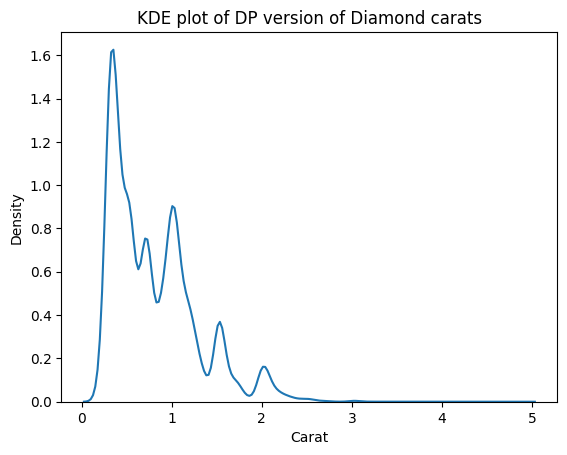

In [16]:
sns.kdeplot(x=dp_carat)
plt.xlabel("Carat")
plt.title("KDE plot of DP version of Diamond carats");

Looks good. Now, let's do on the open-source version:

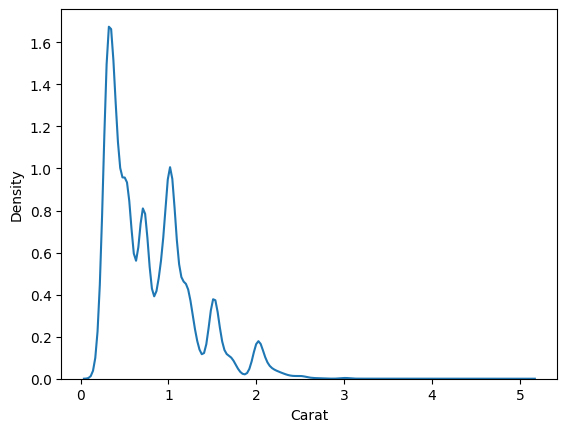

In [17]:
sns.kdeplot(x=diamonds["carat"])

plt.xlabel("Carat");

The two plots are almost identical, which validates that __histogram binning__ is a viable method for drawing differentially private visuals.

## Creating two variable plots with histogram binning

Histogram binning works greatly for single variable plots - histograms, box plots, violin plots, you name it. But it has a glaring downside when it comes to two or more variable plots. Have you noticed it?

Since histogram binning uses differentially private histograms under the hood, the recreated distributions will never have the same length:

This becomes a problem because for n-variable plots, all involved columns must have the same length. Because of noise added by histogram binning, columns will have varying lengths. 

For two-variable plots such as plain scatterplots, the problem can be solved by using a 2D histogram. Let's say you have two distributions, X and Y. They have the following relationship if a scatterplot is used:

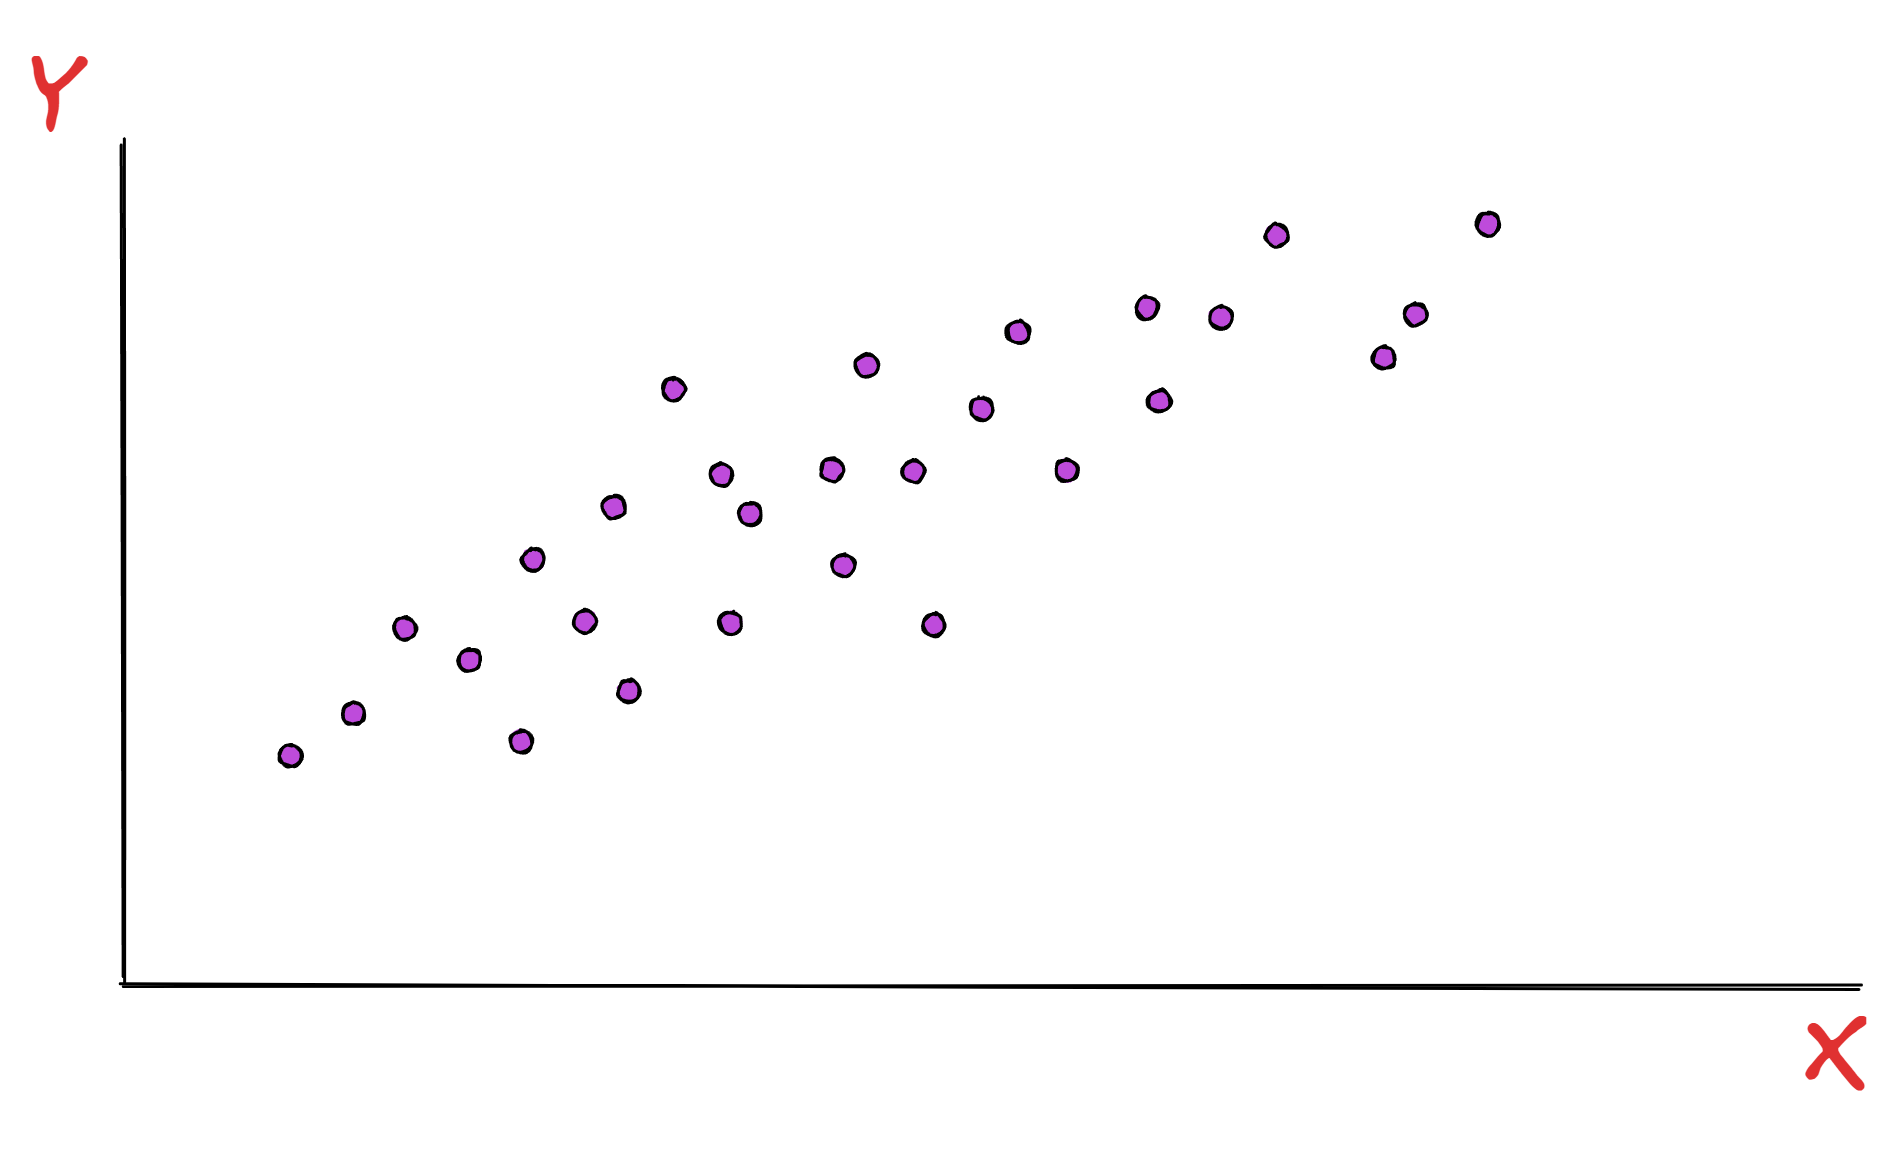

To extend the histogram binning idea to a scatterplot histogram, we need to think about in terms of a grid instead of bins to divide the plot:

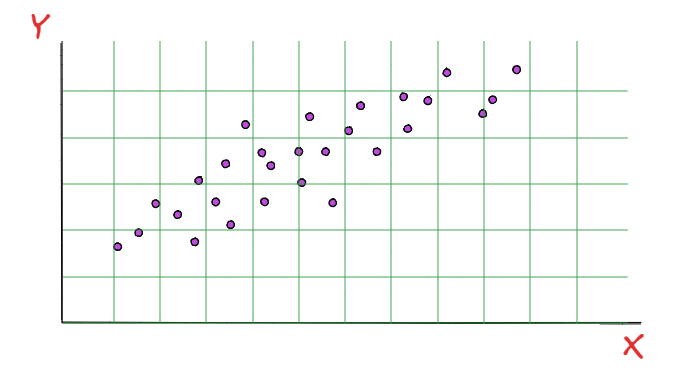

Then, when we resample the distribution with histogram binning, we would be sampling the same number of random points in each grid cell as calculated by a 2D histogram count. Essentially, we would be moving the dots around in their respective cells like this:

![](images/scatterplot.gif)

The random nature of histogram binning might also add few extra points in each cell. Regardless, the original trend of the scatterplot would be preserved and DP would be achieved. 

Here is a function our team wrote to implement the __2D histogram binning__ method:

In [18]:
%%ag


def dp_scatterplot(
    pdf: PrivateDataFrame, x: str, y: str, eps: int = 1, bins: int = 100
):
    # Generate a 2D grid bounded by the given distributions
    counts, x_edges, y_edges = pdf.hist2d(eps=eps, x=x, y=y, bins=bins)

    # Create empty lists to store DP distributions
    xs = []
    ys = []

    # Apply uniform sampling for each cell in the grid
    # We uniformly sample new points bounded by the ranges of each cell
    # The number of new points in each cell is controlled by `counts` generated above
    for x in range(len(x_edges) - 1):
        for y in range(len(y_edges) - 1):
            # Define the ranges for the current cell
            low_x = x_edges[x]
            high_x = x_edges[x + 1]

            low_y = y_edges[y]
            high_y = y_edges[y + 1]

            # Extract the count for the current cell
            c = counts[x, y]

            # Clip the count based on the standard error of Laplace distribution
            # This is based on the fact that hist2d generates cell counts with...
            # ...noise drawn using the Laplace mechanism
            # Sample new points uniformly within each grid cell's range
            new_points_x = np.random.uniform(low=low_x, high=high_x, size=int(c))
            new_points_y = np.random.uniform(low=low_y, high=high_y, size=int(c))

            # Add the points to final distributions
            xs.extend(new_points_x)
            ys.extend(new_points_y)

    return xs, ys

It looks very much like the 1D version but with few notable differences:

1. The function requires the names of two columns `x` and `y`.
2. Instead of the `.hist`, we are using the `.hist2d` function, which returns three variables - the grid cell counts, the X and Y coordinates of each grid line.
3. We are returning two distributions.

You can verify that both arrays have the same length now:

In [21]:
%%ag

x, y = dp_scatterplot(train_x, x="carat", y="depth")

export(x, "x")
export(y, "y")

Setting up exported variable in local environment: x
Setting up exported variable in local environment: y


In [22]:
len(x) == len(y)

True

Let's try plotting them:

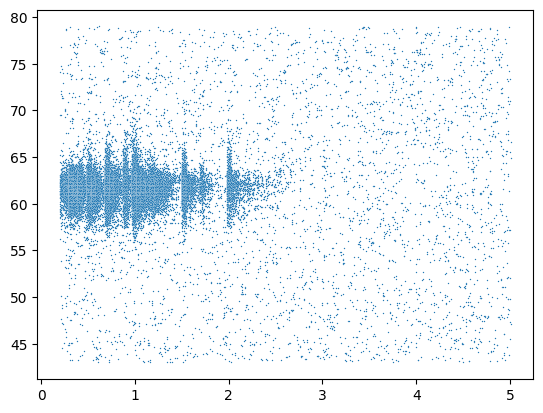

In [25]:
sns.scatterplot(x=x, y=y, s=1);

It seems that the plot has some unnatural-looking clumps of dots randomly scattered over the graph (too much noise). That is due to random noise as histogram binning may return counts even though there aren't any points in the original cell. 

When we saw this plot, our team added a single line of code that clipped the returned counts based on the standard error of the Laplace distribution:

In [27]:
%%ag


def dp_scatterplot(
    pdf: PrivateDataFrame, x: str, y: str, eps: int = 1, bins: int = 100
):
    # Generate a 2D grid bounded by the given distributions
    counts, x_edges, y_edges = pdf.hist2d(eps=eps, x=x, y=y, bins=bins)

    # Create empty lists to store DP distributions
    xs = []
    ys = []

    # Apply uniform sampling for each cell in the grid
    # We uniformly sample new points bounded by the ranges of each cell
    # The number of new points in each cell is controlled by `counts` generated above
    for x in range(len(x_edges) - 1):
        for y in range(len(y_edges) - 1):
            # Define the ranges for the current cell
            low_x = x_edges[x]
            high_x = x_edges[x + 1]

            low_y = y_edges[y]
            high_y = y_edges[y + 1]

            # Extract the count for the current cell
            c = counts[x, y]

            # Clip the count based on the standard error of Laplace distribution
            # This is based on the fact that hist2d generates cell counts with...
            # ...noise drawn using the Laplace mechanism
            if c > 3 * (2**0.5) * eps:
                # Sample new points uniformly within each grid cell's range
                new_points_x = np.random.uniform(low=low_x, high=high_x, size=int(c))
                new_points_y = np.random.uniform(low=low_y, high=high_y, size=int(c))

                # Add the points to final distributions
                xs.extend(new_points_x)
                ys.extend(new_points_y)

    return xs, ys

When we tried this version of the function, we got a much cleaner looking scatterplot:

In [28]:
%%ag

x, y = dp_scatterplot(train_x, x="carat", y="depth")

export(x, "x")
export(y, "y")

Setting up exported variable in local environment: x
Setting up exported variable in local environment: y


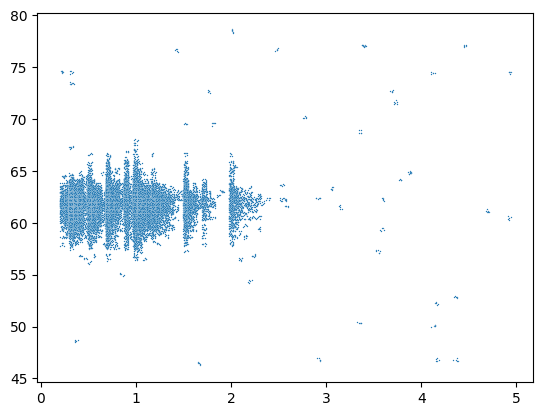

In [29]:
sns.scatterplot(x=x, y=y, s=1);

For comparison, here is a scatterplot drawn using the original distributions:

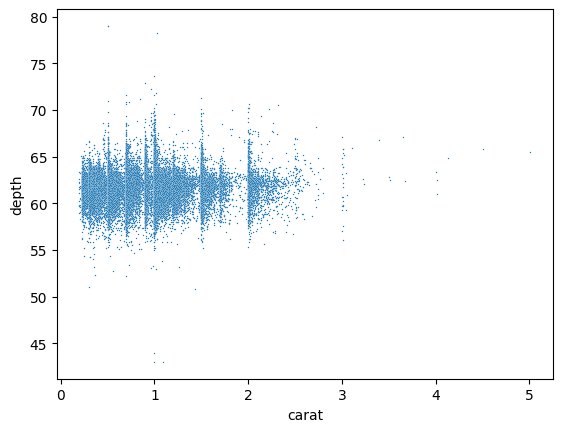

In [30]:
sns.scatterplot(x="carat", y="depth", data=diamonds, s=1);

When we put the two plots side-by-side, we again get validation that histogram binning works:

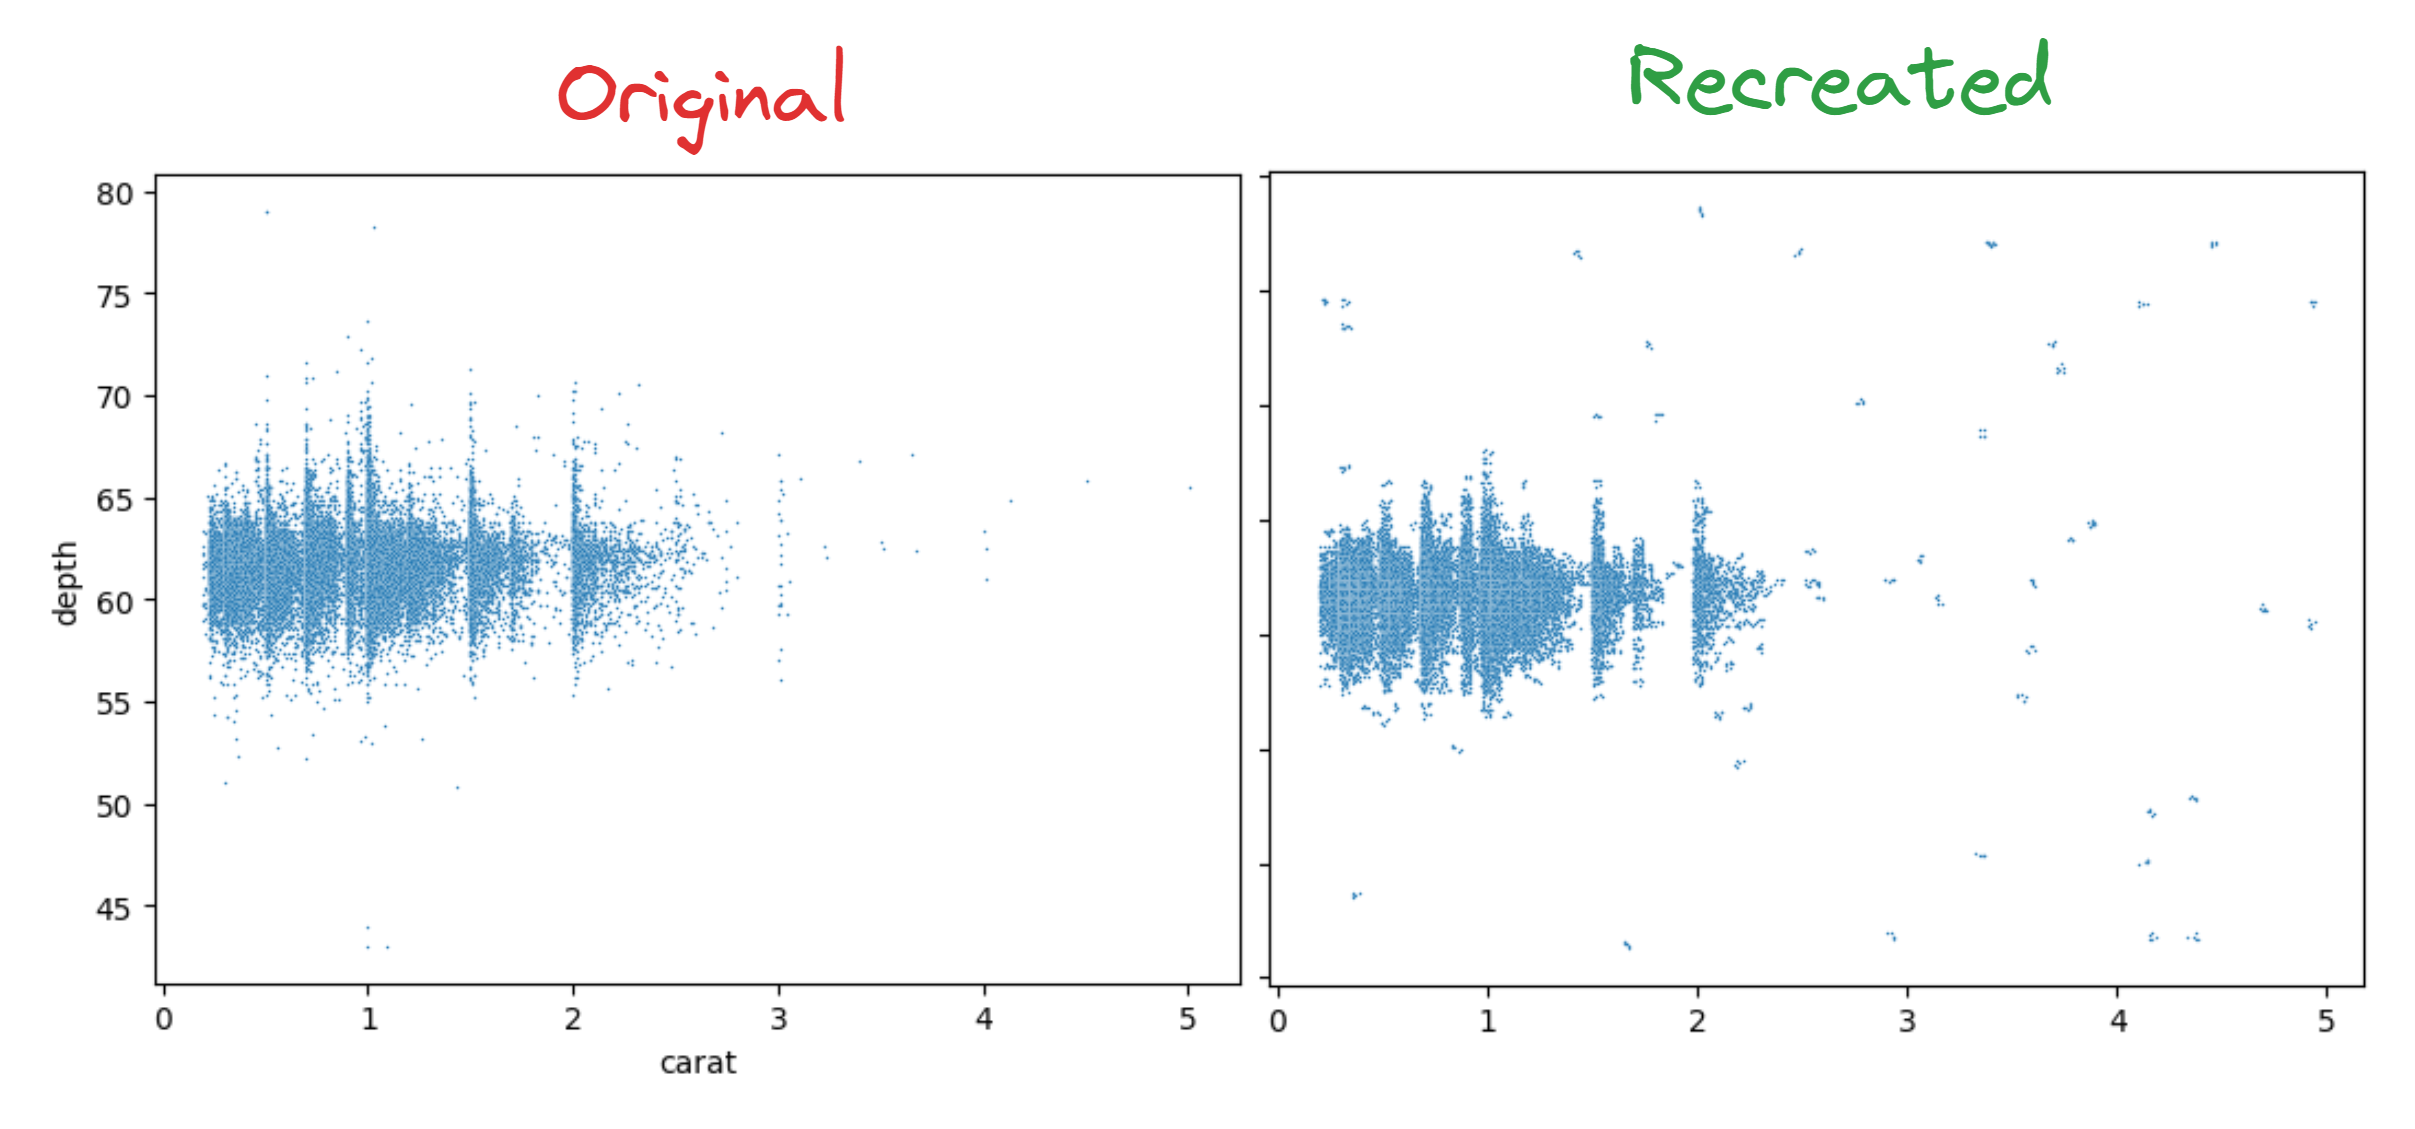

## Conclusion

We've addressed a painful aspect of differentially private data science - data visualization. Traditionally, common graphs such as histograms, boxplots or scatterplots weren't possible to create because of the strict privacy guidelines of differential privacy. 

This article proposed a novel approach our team came up with that allows nearly any visualization on differentially private data. We've named it as __histogram binning__ as the method uses DP histograms under the hood. Through examples, we've seen first-hand that this method works as the differentially private plots we have created very closely matches those created on the same open-source dataset.

Since histogram binning is relatively new, we won't claim it is perfect. We still have to figure out a reliable approach for creating visuals beyond just two variables. Also, the functions written in this article should be thoroughly checked and eventually added as internal methods of private dataframes in the Antigranular platform. 

Thank you for reading!